In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a toy dataset
def generate_data(num_samples):
    # Generate random 2D positions (x, y)
    x = np.random.rand(num_samples, 2)
    
    # Define a simple function to transform (x, y) to (x, y, z)
    def transform_function(x, y):
        z = 2*x + 3*y  # A simple linear transformation
        return np.array([x, y, z])
    
    # Apply the transformation to generate 3D vectors
    y = np.apply_along_axis(lambda row: transform_function(row[0], row[1]), axis=1, arr=x)
    
    return x, y

In [3]:
# Data parameters
num_samples = 1000

# Create the dataset
x_train, y_train = generate_data(num_samples)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2 , 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3 )

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self .norm(self.fc3(x))
        return x

    def norm(self, x):
        x = x/torch.norm(x, dim=1, keepdim=True)
        return x

In [5]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 1000

# Create the model and optimizer
model = Model()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [6]:
# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

In [7]:
# Save the trained model
# torch.save(model.state_dict(), 'Model.pth')

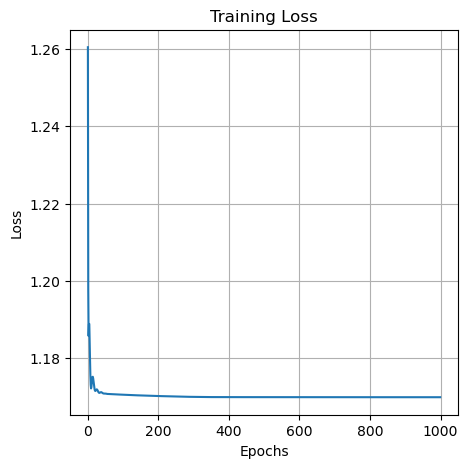

In [8]:
# Plot the loss curve
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [9]:
# Test the model
test_input = torch.tensor([[0.5, 0.6]], dtype=torch.float32)
predicted_output = model(test_input)
print("Input:", test_input.numpy())
print("Predicted Output:", predicted_output.detach().numpy())

Input: [[0.5 0.6]]
Predicted Output: [[0.1735106  0.20721172 0.96278626]]
